## Accessing DM-EFD data


In this notebook, I used Robert Lupton's code that unpacks the 100 samples/second datapoints in the EFD
to plot the Nasmyth2 motor torque during a run when we were varying the Nasmyth2 angle to investigate
the horizontal banding problem caused (probably) by electrical noise.

In [1]:
import sys, time, os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.fft import fft, fftfreq

from astropy.time import Time, TimeDelta
from lsst_efd_client import EfdClient

We'll access the EFD instance deployed at the Summit.

In [2]:
client = EfdClient('summit_efd')

In [3]:
topics = await client.get_topics()
for topic in topics:
    items = topic.split('.')
    if items[2] == "ATMCS":
        print(topic)

lsst.sal.ATMCS.ackcmd
lsst.sal.ATMCS.azEl_mountMotorEncoders
lsst.sal.ATMCS.command_abort
lsst.sal.ATMCS.command_disable
lsst.sal.ATMCS.command_enable
lsst.sal.ATMCS.command_exitControl
lsst.sal.ATMCS.command_setInstrumentPort
lsst.sal.ATMCS.command_standby
lsst.sal.ATMCS.command_start
lsst.sal.ATMCS.command_startTracking
lsst.sal.ATMCS.command_stopTracking
lsst.sal.ATMCS.command_trackTarget
lsst.sal.ATMCS.logevent_allAxesInPosition
lsst.sal.ATMCS.logevent_appliedSettingsMatchStart
lsst.sal.ATMCS.logevent_atMountState
lsst.sal.ATMCS.logevent_azimuthBrake1
lsst.sal.ATMCS.logevent_azimuthBrake2
lsst.sal.ATMCS.logevent_azimuthDrive1Status
lsst.sal.ATMCS.logevent_azimuthDrive2Status
lsst.sal.ATMCS.logevent_azimuthInPosition
lsst.sal.ATMCS.logevent_azimuthLimitSwitchCCW
lsst.sal.ATMCS.logevent_azimuthLimitSwitchCW
lsst.sal.ATMCS.logevent_azimuthToppleBlockCCW
lsst.sal.ATMCS.logevent_azimuthToppleBlockCW
lsst.sal.ATMCS.logevent_elevationBrake
lsst.sal.ATMCS.logevent_elevationDriveStatus
lsst

In [4]:
# Lupton's unpacking code

def merge_packed_time_series(packed_dataframe, base_field, stride=1, 
                             ref_timestamp_col="cRIO_timestamp", internal_time_scale="tai"):
    """Select fields that are time samples and unpack them into a dataframe.
            Parameters
            ----------
            packedDF : `pandas.DataFrame`
                packed data frame containing the desired data
            base_field :  `str`
                Base field name that will be expanded to query all
                vector entries.
            stride : `int`, optional
                Only use every stride value when unpacking.  Must be a factor
                of the number of packed values.
                (1 by default)
            ref_timestamp_col : `str`, optional
                Name of the field name to use to assign timestamps to unpacked
                vector fields (default is 'cRIO_timestamp').
            internal_time_scale : `str`, optional
                Time scale to use when converting times to internal formats
                ('tai' by default). Equivalent to EfdClient.internal_scale
        Returns
            -------
            result : `pandas.DataFrame`
                A `pandas.DataFrame` containing the results of the query.
            """
    
    packed_fields = [k for k in packed_dataframe.keys() if k.startswith(base_field)]
    packed_fields = sorted(packed_fields, key=lambda k: int(k[len(base_field):]))  # sort by pack ID
    npack = len(packed_fields)
    if npack%stride != 0:
        raise RuntimeError(f"Stride must be a factor of the number of packed fields: {stride} v. {npack}")
    packed_len = len(packed_dataframe)
    n_used = npack//stride   # number of raw fields being used
    output = np.empty(n_used*packed_len)
    times = np.empty_like(output, dtype=packed_dataframe[ref_timestamp_col][0])
    
    if packed_len == 1:
        dt = 0
    else:
        dt = (packed_dataframe[ref_timestamp_col][1] - packed_dataframe[ref_timestamp_col][0])/npack
    for i in range(0, npack, stride):
        i0 = i//stride
        output[i0::n_used] = packed_dataframe[f"{base_field}{i}"]
        times[i0::n_used] = packed_dataframe[ref_timestamp_col] + i*dt
     
    timestamps = Time(times, format='unix', scale=internal_time_scale).datetime64
    return pd.DataFrame({base_field:output, "times":times}, index=timestamps)

In [5]:
t_end = Time("2021-02-02T15:30:00", scale='tai')   # timestamp at end of desired data 
nsec = 3*3600 # how many seconds of data to retrieve
nasmyth_torque = await client.select_time_series("lsst.sal.ATMCS.measuredTorque", ['*'],
                                              t_end - TimeDelta(nsec, format='sec'), t_end)
torque = merge_packed_time_series(nasmyth_torque, 'nasmyth2MotorTorque', stride=1)
nasmyth_angle = await client.select_time_series("lsst.sal.ATMCS.mount_Nasmyth_Encoders", ['*'],
                                              t_end - TimeDelta(nsec, format='sec'), t_end)
angle = merge_packed_time_series(nasmyth_angle, 'nasmyth2CalculatedAngle', stride=1)


In [6]:
# What's in them?
for col in torque.columns: 
    print(col) 
torqueList = torque.values.tolist()
for col in angle.columns: 
    print(col) 
angleList = angle.values.tolist()

nasmyth2MotorTorque
times
nasmyth2CalculatedAngle
times


In [7]:
# There are ~ 2h30m of data,
# so there should be ~150*60*100 = 900,000 datapoints
# so it's about right
print(len(torqueList))
print(torqueList[985]) # torque, timestamp
print(len(angleList))
print(angleList[985]) # angle, timestamp

871700
[0.2343, 1612268971.6747649]
871700
[9.999998743092874, 1612268970.4317582]


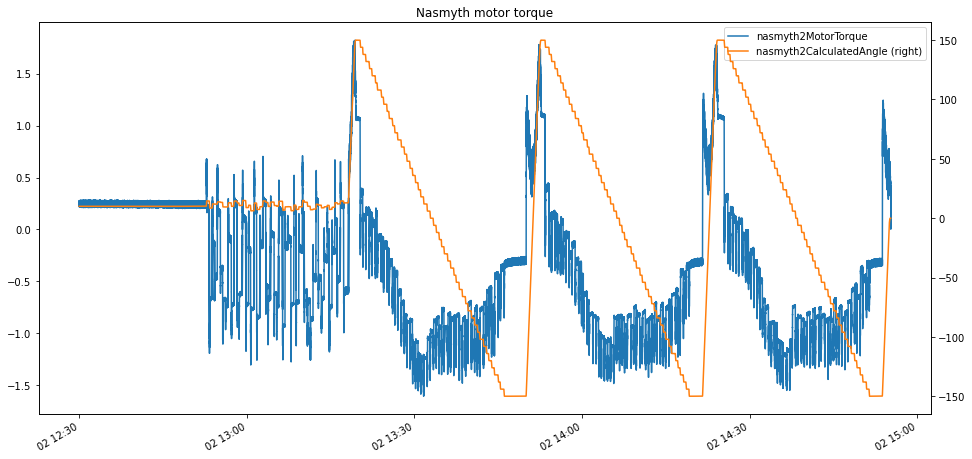

In [8]:
torque['nasmyth2MotorTorque'].plot(figsize=(16,8), title='Nasmyth motor torque', legend=True)
angle['nasmyth2CalculatedAngle'].plot(legend=True, secondary_y=True)
plt.savefig("/home/craiglagegit/DATA/Nasmyth2_Torque_02Feb21.pdf")

In [9]:
# FFT of torque data series to look for frequency peaks
# First extract just the torque data
torqueArray = np.array(torque.values.tolist())[:,0]
print(torqueArray[0:10])

[0.2508 0.264  0.2508 0.2376 0.2376 0.2574 0.2409 0.2244 0.2607 0.2706]


In [10]:
# Do the FFT
SAMPLE_RATE = 100 # 100 Hz sampling frequency
N = len(torqueArray)
yf = fft(torqueArray)
xf = fftfreq(N, 1 / SAMPLE_RATE)

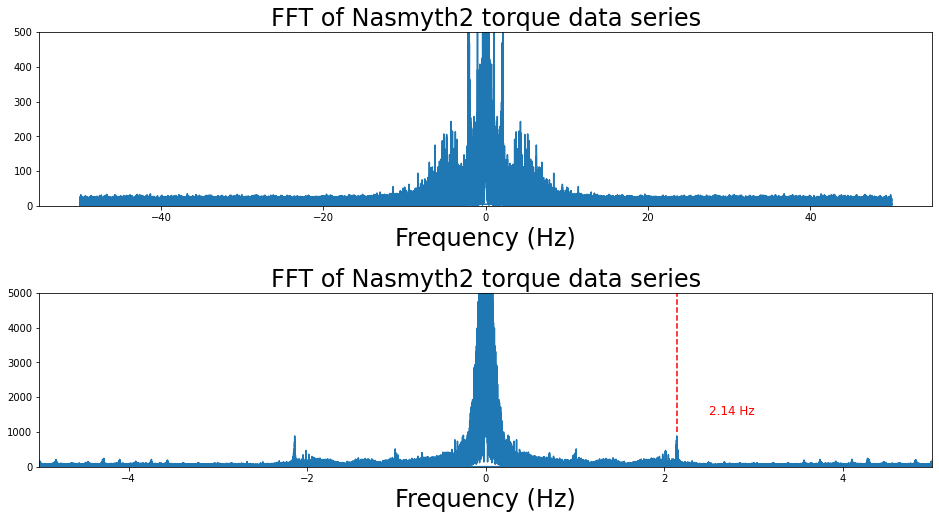

In [21]:
# Now plot it
plt.figure(figsize=(16,8))
plt.subplot(2,1,1)
plt.subplots_adjust(hspace=0.5)
plt.plot(xf, np.abs(yf))
plt.title("FFT of Nasmyth2 torque data series", fontsize=24)
plt.xlabel("Frequency (Hz)",fontsize=24)
plt.ylim(0,500)
plt.subplot(2,1,2)
plt.plot(xf, np.abs(yf))
plt.title("FFT of Nasmyth2 torque data series", fontsize=24)
plt.xlabel("Frequency (Hz)",fontsize=24)
plt.ylim(0,5000)
plt.xlim(-5,5)
plt.plot([2.14,2.14],[1000,5000], ls='--', color='red')
plt.text(2.5, 1500, "2.14 Hz", fontsize=12, color='red')
plt.savefig("/home/craiglagegit/DATA/Nasmyth2_Torque_FFT_04Feb21.pdf")

In [ ]:
# Let's look at some blow-ups

In [ ]:
t_end = Time("2021-02-02T13:10:00", scale='tai')   # timestamp at end of desired data 
nsec = 15*60 # how many seconds of data to retrieve
nasmyth_torque = await client.select_time_series("lsst.sal.ATMCS.measuredTorque", ['*'],
                                              t_end - TimeDelta(nsec, format='sec'), t_end)
torque = merge_packed_time_series(nasmyth_torque, 'nasmyth2MotorTorque', stride=1)
nasmyth_angle = await client.select_time_series("lsst.sal.ATMCS.mount_Nasmyth_Encoders", ['*'],
                                              t_end - TimeDelta(nsec, format='sec'), t_end)
angle = merge_packed_time_series(nasmyth_angle, 'nasmyth2CalculatedAngle', stride=1)


In [ ]:
torque['nasmyth2MotorTorque'].plot(figsize=(16,8), title='Nasmyth motor torque', legend=True)
angle['nasmyth2CalculatedAngle'].plot(legend=True, secondary_y=True)
plt.savefig("/home/craiglagegit/DATA/Nasmyth2_Torque_Blowup_02Feb21.pdf")

In [ ]:
t_end = Time("2021-02-02T13:09:25", scale='tai')   # timestamp at end of desired data 
nsec = 10 # how many seconds of data to retrieve
nasmyth_torque = await client.select_time_series("lsst.sal.ATMCS.measuredTorque", ['*'],
                                              t_end - TimeDelta(nsec, format='sec'), t_end)
torque = merge_packed_time_series(nasmyth_torque, 'nasmyth2MotorTorque', stride=1)
nasmyth_angle = await client.select_time_series("lsst.sal.ATMCS.mount_Nasmyth_Encoders", ['*'],
                                              t_end - TimeDelta(nsec, format='sec'), t_end)
angle = merge_packed_time_series(nasmyth_angle, 'nasmyth2CalculatedAngle', stride=1)


In [ ]:
torque['nasmyth2MotorTorque'].plot(figsize=(16,8), title='Nasmyth motor torque', legend=True)
angle['nasmyth2CalculatedAngle'].plot(legend=True, secondary_y=True)
plt.savefig("/home/craiglagegit/DATA/Nasmyth2_Torque_Blowup2_02Feb21.pdf")

In [ ]:
t_end = Time("2021-02-02T13:09:25", scale='tai')   # timestamp at end of desired data 
nsec = 2 # how many seconds of data to retrieve
nasmyth_torque = await client.select_time_series("lsst.sal.ATMCS.measuredTorque", ['*'],
                                              t_end - TimeDelta(nsec, format='sec'), t_end)
torque = merge_packed_time_series(nasmyth_torque, 'nasmyth2MotorTorque', stride=1)
nasmyth_angle = await client.select_time_series("lsst.sal.ATMCS.mount_Nasmyth_Encoders", ['*'],
                                              t_end - TimeDelta(nsec, format='sec'), t_end)
angle = merge_packed_time_series(nasmyth_angle, 'nasmyth2CalculatedAngle', stride=1)


In [ ]:
torque['nasmyth2MotorTorque'].plot(figsize=(16,8), title='Nasmyth motor torque', legend=True)
#angle['nasmyth2CalculatedAngle'].plot(legend=True, secondary_y=True)
plt.savefig("/home/craiglagegit/DATA/Nasmyth2_Torque_Blowup3_02Feb21.pdf")